![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Machine Learning for Finance - Assignment 1

### by Amber Walker and Clarice Mottet
### All work was distributed and completed equally.

0. **[Part 0: Set Up and Import](#part0)**
- **Objective**: Initialize programming environment and data.
- **Tasks:**
  - Initialize libraries.
  - Import data into the programming environment.
  - Conduct preprocessing.

1. **[Part 1: EWMA Based Variance](#part1)**
- **Objective**: Compare two models to calculate EWMA Based Variance
- **Tasks:**
  - EWMA Equation: Use the equation covered in class to calculate EWMA based variance.
  - EWMA Recursion: Use the recursive formula definition to calculate EWMA based variance.
  - Calculate regular historical volatility.
  - Compare the two methods to calculate EWMA based variance to the regular historical volatility benchmark.

2. **[Part 2: Causality Analysis](#part2)**
- **Objective**: Conduct causality analysis with multiple lag variables and time frame windows.
- **Tasks:**
  - task list here

3. **[Part 3: Modeling](#part3)**
- **Objective**: Create a neural network and a gaussian process regression to model return, price, or direction (up or down).
- **Tasks:**
  - (I think we should predict a binary outcome of the stock direction goes up or down personally)
  - Feature creation: Create multiple types of lag variables for different lag amounts.
  - Feature selection: (I'd suggest a good old random forest cause I personally love a random forest feature selection or an XGBoost feature selection).
  - Create a neural network, discuss hyper parameter tuning.
  - Create a gaussian process, discuss hyper parameter tuning.

4. **[Part 4: Further Analysis](#part4)**
- **Objective**: Discuss modeling aspects and compare methods.
- **Tasks:**
  - Create an ARMA model and compare to the neural network and gaussian process.
  - Discuss if bootstrapping would aid model performance and efficacy and what modeling would look like with the incorporation of stationary bootstrapping.


## <a id='part0'>Part 0: Set Up and Import</a>
- **Objective**: Initialize programming environment and data.
- **Tasks:**
  - Initialize libraries.
  - Import data into the programming environment.
  - Conduct preprocessing.

In [19]:
#Libraries
import pandas as pd
import numpy as np
import os
import gc
import datetime
import yfinance as yf
# from google.colab import drive
# drive.mount('/content/drive')

#Paths
path_in_ = r'/home/clarice/Documents/VSCode/Term3/ML_Finance/MLF_HW1/inputs/'
path_out_ = r'/home/clarice/Documents/VSCode/Term3/ML_Finance/MLF_HW1/outputs/'
# path_in_ = r'/content/drive/MyDrive/ML_Finance/MLF_HW1/inputs/'
# path_out_ = r'/content/drive/MyDrive/ML_Finance/MLF_HW1/outputs/'

#Global Variables

#used in EWMA calculations
PARAM_LAMBDA = .94
PARAM_M = 20

In [2]:
#Import

#using a text file we created from an R file
df_market = pd.read_csv(path_in_ + 'WorldMarkets99_20.txt', sep = '|', dtype = str)
df_market.columns = df_market.columns.str.lower().str.strip()
df_market[['open','high','low','close','volume','adjusted']] = df_market[['open','high','low','close','volume','adjusted']].apply(pd.to_numeric)
df_market['date'] = pd.to_datetime(df_market['date'])
df_market.sort_values(by = ['market','date'], inplace = True)
df_market.reset_index(drop = True, inplace = True)

df_market.describe()

,open,high,low,close,volume,adjusted,date
count,69035.000000,69035.000000,69035.000000,69035.000000,6.903500e+04,69035.000000,70078
mean,11464.128611,11555.368887,11366.426424,11462.595335,4.028610e+08,11462.588664,2009-08-02 18:18:57.361225984
min,9.010000,9.310000,8.560000,9.140000,0.000000e+00,9.140000,1999-01-04 00:00:00
25%,1891.545044,1907.417481,1872.669983,1890.239990,8.400000e+03,1890.239990,2004-03-19 00:00:00
50%,6737.540039,6785.109863,6682.490234,6733.229980,4.237800e+06,6733.204102,2009-07-21 00:00:00
75%,11869.479981,11951.899903,11773.080078,11867.850098,1.535236e+08,11867.850098,2014-12-09 00:00:00
max,119528.000000,119593.000000,118108.000000,119528.000000,1.145623e+10,119528.000000,2020-04-30 00:00:00
std,15447.245090,15581.477219,15309.464143,15448.944086,9.914707e+08,15448.946777,NaN


First, we fetch the data from 12/30/98 for each market and add it to our df so that we can .ffill() that data to the first missing values. There is no data for the 31st, so we get the data for the 30th.

In [6]:
#fetch the data for 12/30/98
market_symbols = [
    "^BSESN", "^BVSP", "^FTSE", "^GDAXI", "^GSPC", "^HSCE",
    "^IBEX", "^JKSE", "^MXX", "^N225", "^TWII", "^VLIC", "^VIX"
]
market_countries = [
    "India", "Brazil", "UK", "Germany", "USA", "China-Shanghai",
    "Spain", "Indonesia", "Mexico", "Japan", "Taiwan", "VLIC", "VIX"
]

start_date = datetime.datetime(1998, 12, 30)
end_date = datetime.datetime(1998, 12, 31)

# Function to retrieve and store market data using yfinance
def get_market_data(symbols, start, end):
    data = {}
    for symbol in symbols:
        try:
            ticker = yf.Ticker(symbol)
            data[symbol] = ticker.history(start=start, end=end, auto_adjust=False)
        except Exception as e:
            print(f"Failed to retrieve data for {symbol}: {str(e)}")
    return data

def prepare_data_for_merge(day_before_data):
    all_data = []
    for symbol, df in day_before_data.items():
        if not df.empty:
            df['market'] = symbol  # Add a 'Symbol' column to each DataFrame
            all_data.append(df)
    combined_df = pd.concat(all_data)
    return combined_df

In [7]:
#get market data
day_before_data = get_market_data(market_symbols, start_date, end_date)

# for symbol in market_symbols:
#   print(day_before_data[symbol])

combined_df = prepare_data_for_merge(day_before_data)

In [8]:
combined_df.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,market,Capital Gains
Date,,,,,,,,,,
1998-12-30 00:00:00+05:30,3074.439941,3118.590088,3072.610107,3110.330078,3110.330078,0,0.0,0.0,^BSESN,NaN
1998-12-30 00:00:00-02:00,6715.000000,6865.000000,6712.000000,6784.000000,6784.000000,0,0.0,0.0,^BVSP,NaN
1998-12-30 00:00:00+00:00,5932.700195,5944.899902,5809.000000,5882.600098,5882.600098,0,0.0,0.0,^FTSE,NaN
1998-12-30 00:00:00+01:00,5054.859863,5089.229980,4999.709961,5006.569824,5006.569824,0,0.0,0.0,^GDAXI,NaN
1998-12-30 00:00:00-05:00,1241.810059,1244.930054,1231.199951,1231.930054,1231.930054,594220000,0.0,0.0,^GSPC,NaN


In [9]:
#clean data
combined_df = combined_df.drop(columns=['Dividends', 'Stock Splits', 'Capital Gains'])
combined_df = combined_df.reset_index()
combined_df.rename(columns={'index': 'date'}, inplace=True)
combined_df.rename(columns={'Adj Close': 'adjusted'}, inplace=True)
combined_df.columns = combined_df.columns.str.lower()
combined_df['market'] = combined_df['market'].str.replace('^', '', regex=False)

#remove the timezone
if 'date' in combined_df.columns:
    combined_df['date'] = pd.to_datetime(combined_df['date'], utc=True)
    combined_df['date'] = combined_df['date'].dt.tz_localize(None)
    combined_df['date'] = combined_df['date'].dt.date

display(combined_df.head())

,date,open,high,low,close,adjusted,volume,market
0,1998-12-29,3074.439941,3118.590088,3072.610107,3110.330078,3110.330078,0,BSESN
1,1998-12-30,6715.000000,6865.000000,6712.000000,6784.000000,6784.000000,0,BVSP
2,1998-12-30,5932.700195,5944.899902,5809.000000,5882.600098,5882.600098,0,FTSE
3,1998-12-29,5054.859863,5089.229980,4999.709961,5006.569824,5006.569824,0,GDAXI
4,1998-12-30,1241.810059,1244.930054,1231.199951,1231.930054,1231.930054,594220000,GSPC


### Add missing dates

In [10]:
#first we build a df with all dates (including weekends) for EACH market
start_date = datetime.datetime(1999, 1, 1)
end_date = datetime.datetime(2020, 4, 30)
#date range
dates = pd.date_range(start=start_date, end=end_date, freq='D')
#all of the diff markets
markets = df_market['market'].unique()
#df build
date_df = pd.DataFrame([(date, market) for market in markets for date in dates], columns=['date', 'market'])

print(date_df.head())


        date market
0 1999-01-01  BSESN
1 1999-01-02  BSESN
2 1999-01-03  BSESN
3 1999-01-04  BSESN
4 1999-01-05  BSESN


In [11]:
#merge the market df onto the date_df, so all dates are included
df = date_df.merge(df_market, on=['date', 'market'], how='left')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101283 entries, 0 to 101282
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      101283 non-null  datetime64[ns]
 1   market    101283 non-null  object        
 2   open      69035 non-null   float64       
 3   high      69035 non-null   float64       
 4   low       69035 non-null   float64       
 5   close     69035 non-null   float64       
 6   volume    69035 non-null   float64       
 7   adjusted  69035 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 6.2+ MB


In [12]:
#add on the new data
combined_df['date'] = pd.to_datetime(combined_df['date'])
df['date'] = pd.to_datetime(df['date'])
df = pd.concat([df, combined_df], ignore_index=True).copy()
df = df.sort_values(by='date')

print(df.head())

             date market          open          high           low  \
101286 1998-12-29  GDAXI   5054.859863   5089.229980   4999.709961   
101293 1998-12-29   TWII   6545.779785   6566.549805   6433.450195   
101292 1998-12-29   N225  13832.320312  13913.549805  13812.870117   
101283 1998-12-29  BSESN   3074.439941   3118.590088   3072.610107   
101290 1998-12-29   JKSE    396.915985    398.037994    390.084015   

               close     volume      adjusted  
101286   5006.569824        0.0   5006.569824  
101293   6462.029785        0.0   6462.005371  
101292  13842.169922        0.0  13842.169922  
101283   3110.330078        0.0   3110.330078  
101290    398.037994  1748700.0    398.037994  


### Forward Filling

In [13]:
#df.sort_values(by=['market', 'date'], inplace=True)
columns_to_impute = ['open', 'high', 'low', 'close', 'volume', 'adjusted']

for column in columns_to_impute:
    df[column] = df.groupby(['market'])[column].fillna(method='ffill')

nulls = df.isna().sum()

print(nulls)

date        0
market      0
open        0
high        0
low         0
close       0
volume      0
adjusted    0
dtype: int64


/tmp/ipykernel_16017/1232200106.py:5: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df[column] = df.groupby(['market'])[column].fillna(method='ffill')
/tmp/ipykernel_16017/1232200106.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df.groupby(['market'])[column].fillna(method='ffill')
/tmp/ipykernel_16017/1232200106.py:5: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df[column] = df.groupby(['market'])[column].fillna(method='ffill')
/tmp/ipykernel_16017/1232200106.py:5: FutureWarning: Series.fillna with 'method' is de

In [14]:
df_clean = df[df['date'] >= pd.Timestamp('1999-01-01')]
print(df_clean.head())

            date market         open          high          low        close  \
23373 1999-01-01  GDAXI  5054.859863   5089.229980  4999.709961  5006.569824   
31164 1999-01-01   GSPC  1241.810059   1244.930054  1231.199951  1231.930054   
38955 1999-01-01   HSCE  1715.569946   1733.900024  1706.359985  1724.469971   
46746 1999-01-01   IBEX  9940.700195  10054.900391  9822.200195  9836.599609   
93492 1999-01-01   VLIC   427.079987    428.839996   426.570007   428.420013   

            volume     adjusted  
23373          0.0  5006.569824  
31164  594220000.0  1231.930054  
38955          0.0  1724.469971  
46746          0.0  9836.589844  
93492    5970000.0   428.420013  


In [15]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101283 entries, 23373 to 77909
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      101283 non-null  datetime64[ns]
 1   market    101283 non-null  object        
 2   open      101283 non-null  float64       
 3   high      101283 non-null  float64       
 4   low       101283 non-null  float64       
 5   close     101283 non-null  float64       
 6   volume    101283 non-null  float64       
 7   adjusted  101283 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 7.0+ MB


In pandas, the dayofweek attribute returns an integer for each date, where Monday is 0 and Sunday is 6. Saturday (5) and Sunday (6) can be identified as weekends.

In [16]:
#we use the pandas dayofweek attribute to create a new feature indicating whether the day is on the weekend or not
df_clean['weekend'] = (df_clean['date'].dt.dayofweek > 4).astype(int)

print(df_clean.head)

<bound method NDFrame.head of             date market          open          high           low  \
23373 1999-01-01  GDAXI   5054.859863   5089.229980   4999.709961   
31164 1999-01-01   GSPC   1241.810059   1244.930054   1231.199951   
38955 1999-01-01   HSCE   1715.569946   1733.900024   1706.359985   
46746 1999-01-01   IBEX   9940.700195  10054.900391   9822.200195   
93492 1999-01-01   VLIC    427.079987    428.839996    426.570007   
...          ...    ...           ...           ...           ...   
7790  2020-04-30  BSESN  32311.039063  32897.589844  32171.650391   
93491 2020-04-30    VIX     32.480000     33.189999     30.709999   
85700 2020-04-30   TWII  10656.400391  10794.830078  10656.400391   
70118 2020-04-30    MXX  36095.718750  36976.648438  36095.718750   
77909 2020-04-30   N225  20105.679688  20365.890625  20084.830078   

              close       volume      adjusted  weekend  
23373   5006.569824          0.0   5006.569824        0  
31164   1231.930054  5942

/tmp/ipykernel_16017/2837093159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['weekend'] = (df_clean['date'].dt.dayofweek > 4).astype(int)


In [17]:
nulls = df_clean.isna().sum()

print(nulls)

date        0
market      0
open        0
high        0
low         0
close       0
volume      0
adjusted    0
weekend     0
dtype: int64


In [ ]:
# df_clean.to_csv(path_out_ + 'df_clean.csv', index=False)

## <a id='part1'>Part 1: EWMA Based Variance</a>
- **Objective**: Compare two models to calculate EWMA Based Variance
- **Tasks:**
  - EWMA Equation: Use the equation covered in class to calculate EWMA based variance.
  - EWMA Recursion: Use the recursive formula definition to calculate EWMA based variance.
  - Calculate regular historical volatility.
  - Compare the two methods to calculate EWMA based variance to the regular historical volatility benchmark.

- Import in the cleaned stock data.

In [20]:
#Import in the cleaned stock data

df_stocks = pd.read_csv(path_out_ + 'df_clean.csv', dtype = str)
df_stocks['date'] = pd.to_datetime(df_stocks['date'])
df_stocks[['open', 'high', 'low', 'close', 'volume', 'adjusted','weekend']] = df_stocks[['open', 'high', 'low', 'close', 'volume', 'adjusted','weekend']].apply(pd.to_numeric)
df_stocks['market'] = df_stocks['market'].str.strip().str.upper()
df_stocks.sort_values(by = ['market','date'], inplace = True)
df_stocks.reset_index(drop = True, inplace = True)

df_stocks['index_time'] = 1
df_stocks['index_time'] = df_stocks.groupby(by = ['market'])['index_time'].cumsum()

#subset to a smaller population
df_stocks = df_stocks[(df_stocks['market']=='BVSP')|(df_stocks['market']=='MXX')|(df_stocks['market']=='VIX')]

df_stocks.dtypes

date          datetime64[ns]
market                object
open                 float64
high                 float64
low                  float64
close                float64
volume               float64
adjusted             float64
weekend                int64
index_time             int64
dtype: object

- Calculate daily log return on close price - (Lecture 2, Slide 5)

$$ r_{t} = ln(P_{t}) - ln(P_{t-1}) $$

In [17]:
#Calculate daily return on close price

#get previous close day
df_stocks['close_lag1'] = df_stocks.groupby(by = ['market'])['close'].shift(1)

#assume that when we don't have previous close information, it is the same as the current day close
df_stocks['close_lag1'] = df_stocks['close_lag1'].fillna(df_stocks['close'])

#use formula to calculate daily natural log return
df_stocks['return_ln_daily'] = np.log(df_stocks['close']) - np.log(df_stocks['close_lag1'])


- EWMA Equation: Use the equation covered in class to calculate EWMA based variance.

$$\sigma^2_{\text{ewma}}(t) = (1 - \lambda) \sum \limits _{k=1} ^{m} \lambda^{k-1}r^2_{t-k}$$

In [18]:
#EWMA Equation

def ewma_formula(t, M, df_):
    df_calc = df_[(df_['index_time']<=t)&(df_['index_time']>=(t-M))].copy()
    df_calc['index_time_ewma_eqn'] = (t - df_calc['index_time']) - 1
    df_calc['lambda'] = df_calc['index_time_ewma_eqn'].apply(lambda x: PARAM_LAMBDA**x)
    df_calc['index_value'] = df_calc['lambda']*(df_calc['return_ln_daily']**2)
    df_calc.loc[df_calc['index_time']==t, 'index_value'] = 0
    df_calc['ewma_eqn'] = df_calc.groupby(by = ['market'])['index_value'].transform('sum')
    df_calc.sort_values(by = ['market','date'], ascending = [True, False], inplace = True)
    df_calc.drop_duplicates(subset = ['market'], inplace = True)
    df_calc = df_calc[['date','market','ewma_eqn']]
    return df_calc

def ewma_calc(df_):
    df_days = df_.copy()
    df_days['number_of_days'] = 1
    df_days['number_of_days'] = df_days.groupby(by = ['market'])['number_of_days'].transform('sum')
    df_days.drop_duplicates(subset = ['market'], inplace = True)
    iterations = df_days['number_of_days'].max()

    list_ewma_eqn = []
    for t in range(1, iterations+1):
        if t < PARAM_M:
            M = t
        else:
            M = PARAM_M
        df_ewma_eqn = ewma_formula(t, M, df_)
        list_ewma_eqn.append(df_ewma_eqn)

    df_all_ewma_eqn = pd.concat(list_ewma_eqn, ignore_index = True)
    df_ = df_.merge(df_all_ewma_eqn, how = 'left', on = ['market','date'])
    return df_

df_stocks = ewma_calc(df_stocks)


KeyboardInterrupt: 

- EWMA Recursion: Use the recursive formula definition to calculate EWMA based variance.

$$\sigma^2_{\text{ewma}}(t) = \lambda \sigma^2_{\text{ewma}}(t-1) + (1-\lambda)r^2_{t-1}$$

In [10]:
#EWMA Recusion

def ewma_formula_rec(t, market, df_):    
    df_calc = df_[(df_['market']==market)&(df_['index_time']<=t)&(df_['index_time']>=(t-1))].copy()
    df_calc = df_calc[['market','index_time','return_ln_daily','ewma_rec']]
    df_calc['ewma_rec_lag1'] = df_calc['ewma_rec'].shift(1)
    df_calc['ewma_rec'] = PARAM_LAMBDA*df_calc['ewma_rec_lag1'] + (1 - PARAM_LAMBDA)*(df_calc['return_ln_daily']**2)
    df_calc = df_calc[df_calc['index_time']==t]
    return df_calc['ewma_rec'].values[0]

def ewma_calc_rec(df_):
    df_['ewma_rec'] = 0.0

    list_markets = df_['market'].unique().tolist()
    for market in list_markets:
        print(market + ' EWMA recursion calculations started')
        df_days = df_[df_['market']==market].copy()
        iterations = len(df_days['market'])
        for t in range(2, iterations):
            df_.loc[(df_['market']==market)&(df_['index_time']==t), 'ewma_rec'] = ewma_formula_rec(t, market, df_)
    return df_

df_stocks = ewma_calc_rec(df_stocks)


BSESN EWMA recursion calculations started
BVSP EWMA recursion calculations started
FTSE EWMA recursion calculations started
GDAXI EWMA recursion calculations started
GSPC EWMA recursion calculations started
HSCE EWMA recursion calculations started
IBEX EWMA recursion calculations started
JKSE EWMA recursion calculations started
MXX EWMA recursion calculations started
N225 EWMA recursion calculations started
TWII EWMA recursion calculations started


KeyboardInterrupt: 

- Calculate regular historical volatility.

- Compare the two methods to calculate EWMA based variance.

/tmp/ipykernel_25863/2573338602.py:40: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range(start=group_data['date'].iloc[0], end=group_data['date'].iloc[-1], freq='Q')


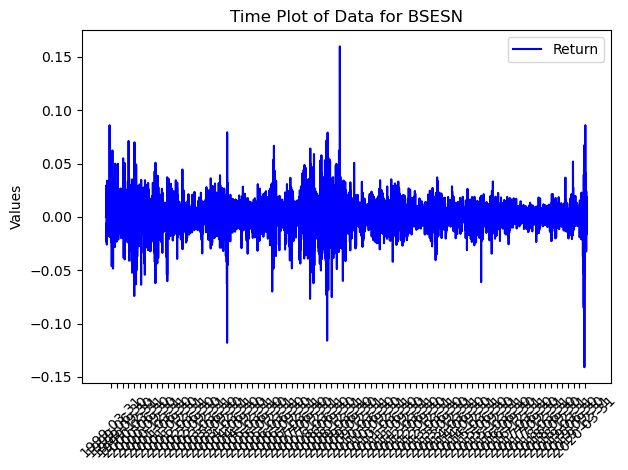

/tmp/ipykernel_25863/2573338602.py:40: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range(start=group_data['date'].iloc[0], end=group_data['date'].iloc[-1], freq='Q')


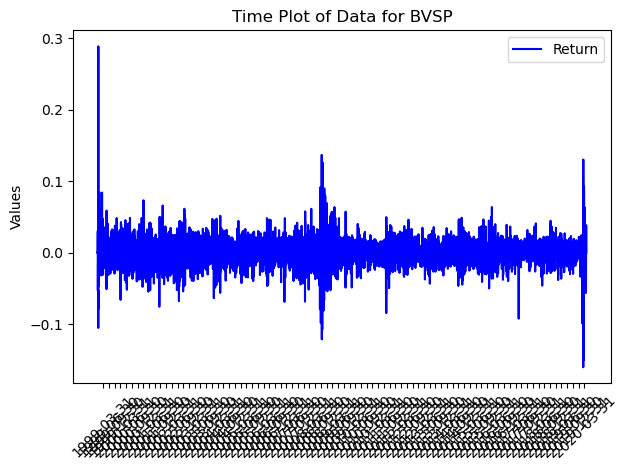

/tmp/ipykernel_25863/2573338602.py:40: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range(start=group_data['date'].iloc[0], end=group_data['date'].iloc[-1], freq='Q')


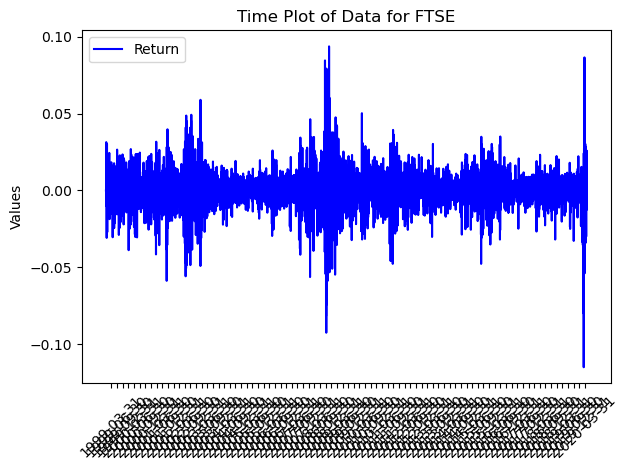

/tmp/ipykernel_25863/2573338602.py:40: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range(start=group_data['date'].iloc[0], end=group_data['date'].iloc[-1], freq='Q')


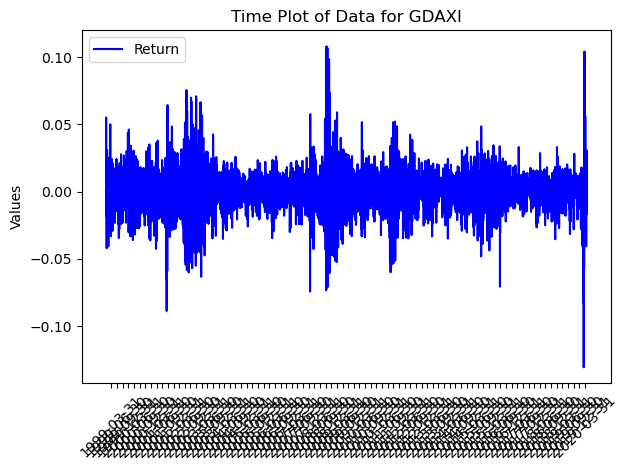

/tmp/ipykernel_25863/2573338602.py:40: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range(start=group_data['date'].iloc[0], end=group_data['date'].iloc[-1], freq='Q')


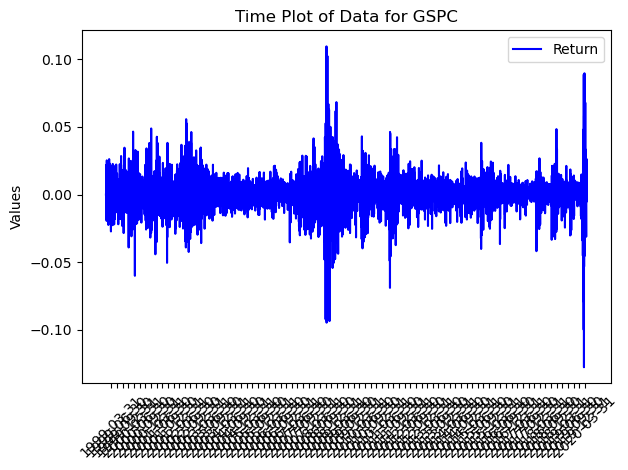

/tmp/ipykernel_25863/2573338602.py:40: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range(start=group_data['date'].iloc[0], end=group_data['date'].iloc[-1], freq='Q')


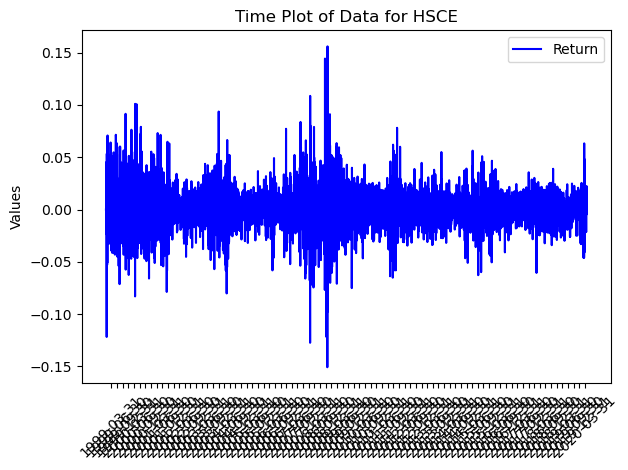

/tmp/ipykernel_25863/2573338602.py:40: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range(start=group_data['date'].iloc[0], end=group_data['date'].iloc[-1], freq='Q')


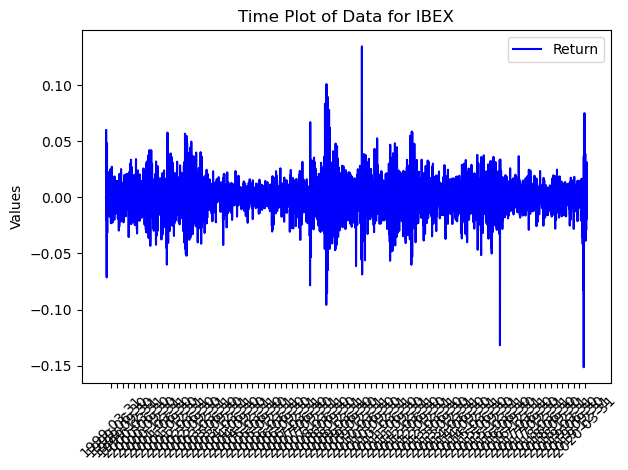

/tmp/ipykernel_25863/2573338602.py:40: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range(start=group_data['date'].iloc[0], end=group_data['date'].iloc[-1], freq='Q')


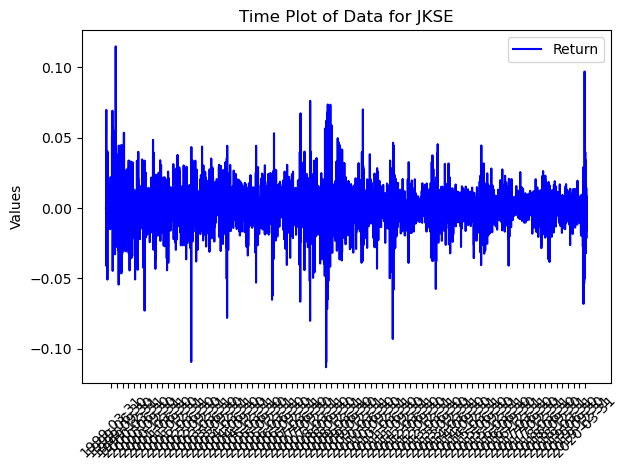

/tmp/ipykernel_25863/2573338602.py:40: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range(start=group_data['date'].iloc[0], end=group_data['date'].iloc[-1], freq='Q')


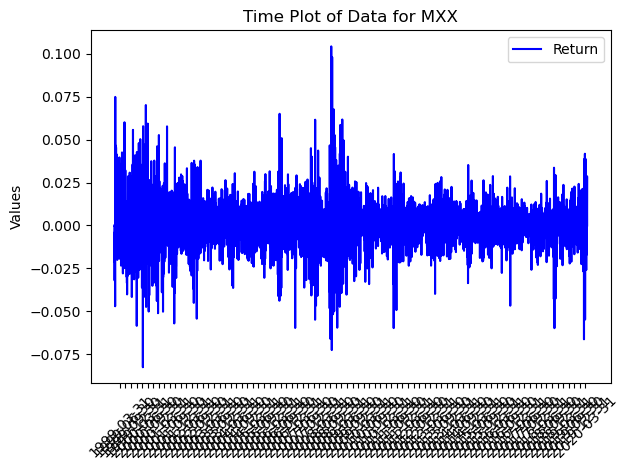

/tmp/ipykernel_25863/2573338602.py:40: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range(start=group_data['date'].iloc[0], end=group_data['date'].iloc[-1], freq='Q')


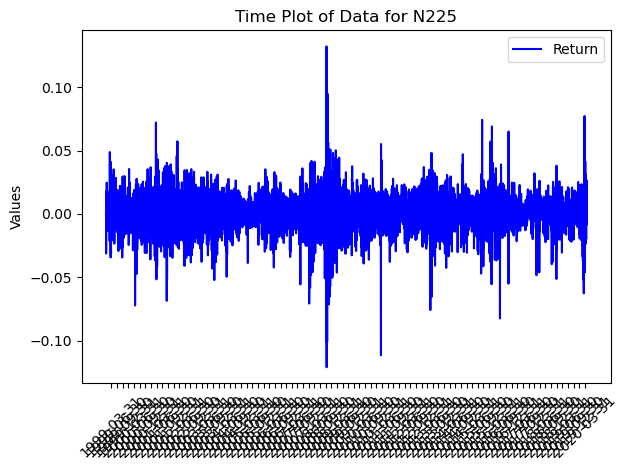

/tmp/ipykernel_25863/2573338602.py:40: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range(start=group_data['date'].iloc[0], end=group_data['date'].iloc[-1], freq='Q')


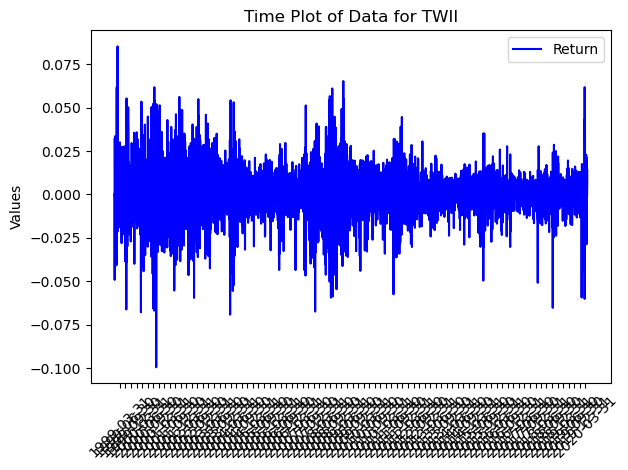

/tmp/ipykernel_25863/2573338602.py:40: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range(start=group_data['date'].iloc[0], end=group_data['date'].iloc[-1], freq='Q')


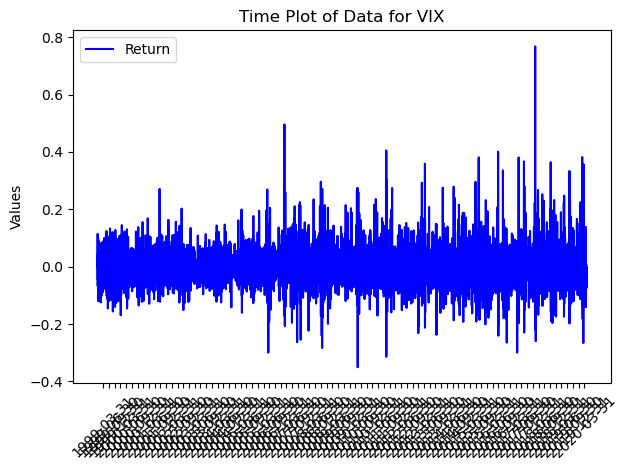

/tmp/ipykernel_25863/2573338602.py:40: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range(start=group_data['date'].iloc[0], end=group_data['date'].iloc[-1], freq='Q')


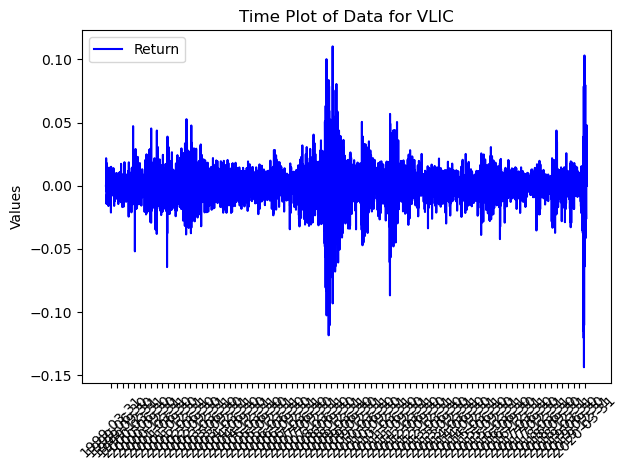

In [15]:
#Graph the two calculations against each other and the daily returns

import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Assuming df_stocks is your DataFrame with columns 'market', 'date', 'return_ln_daily', 'ewma_eqn', and 'ewma_rec'

# Convert 'date' column to datetime if it's not already in datetime format
df_stocks['date'] = pd.to_datetime(df_stocks['date'])

# Group by 'market' column
grouped = df_stocks.groupby('market')

# Iterate over each group
for market, group_data in grouped:
    # print(f"Table for {market}:")
    # print(group_data)
    # print("\n")

    # Create a new figure for each market
    plt.figure()
    
    # Plot the data
    plt.plot(group_data['date'].values, group_data['return_ln_daily'].values, label='Return', color='b')
    # plt.plot(group_data['date'].values, group_data['ewma_eqn'].values, label='EWMA Eqn', linestyle='--', color='g')
    # plt.plot(group_data['date'].values, group_data['ewma_rec'].values, label='EWMA Rec', linestyle=':', color='r')
    
    # Set the y-axis label
    plt.ylabel('Values')
    
    # Set the title
    plt.title(f'Time Plot of Data for {market}')
    
    # Set the legend
    plt.legend()
    
    # Set the x-axis ticks to display just the dates of the start of quarters
    quarters = pd.date_range(start=group_data['date'].iloc[0], end=group_data['date'].iloc[-1], freq='Q')
    plt.xticks(quarters, [quarter.strftime('%Y-%m-%d') for quarter in quarters], rotation=45)
    
    # Display the plot
    plt.tight_layout()
    plt.show()




## <a id='part2'>Part 2: Causality Analysis</a>
- **Objective**: Conduct causality analysis with multiple lag variables and time frame windows.
- **Tasks:**
  - task list here

In [ ]:
#Causality analysis


## <a id='part3'>Part 3: Modeling</a>
- **Objective**: Create a neural network and a gaussian process regression to model return, price, or direction (up or down).
- **Tasks:**
  - (I think we should predict a binary outcome of the stock direction goes up or down personally)
  - Feature creation: Create multiple types of lag variables for different lag amounts.
  - Feature selection: (I'd suggest a good old random forest cause I personally love a random forest feature selection or an XGBoost feature selection).
  - Create a neural network, discuss hyper parameter tuning.
  - Create a gaussian process, discuss hyper parameter tuning.

  2018/01 - 2021/12
dp, svar, bm

In [1]:
#modeling
sp500 = pd.read_csv(path_in_ + 'goyal-welch2022Monthly.csv')
data = sp500.loc['201501':'201812']

NameError: name 'pd' is not defined

In [ ]:
data = sp500.loc['1925-01-01':'2012-12-31']
data['SP500'].plot()

KeyError: 'SP500'

## <a id='part4'>Part 4: Further Analysis</a>
- **Objective**: Discuss modeling aspects and compare methods.
- **Tasks:**
  - Create an ARMA model and compare to the neural network and gaussian process.
  - Discuss if bootstrapping would aid model performance and efficacy and what modeling would look like with the incorporation of stationary bootstrapping.

In [ ]:
#ARMA model


In [ ]:
#Compare ARMA model to NN and Gaussian Process Regression


In [ ]:
#Stationary Bootstrapping


In [ ]:
#Modeling with Stationary Bootstrapping (if necessary)
